# Final Use Case Analysis - Bringing in 10ks

In [1]:
import os
import re
import string
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now


import nltk
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from stop_words import get_stop_words

from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.utils import lemmatize
from gensim.models import Phrases 
from gensim.models.phrases import Phraser
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.models import TfidfModel
from gensim.test.utils import datapath
from pprint import pprint

import pyLDAvis.gensim

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christian.conroy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christian.conroy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load in Data and Convert to PD DF

In [2]:
comp10ks = []
html_regex = re.compile(r'<.*?>')
file = '836809_10-K_2018-10-15_0001654954-18-011177.txt'
with open(file, 'r', encoding='utf8') as text_file:
    text_data = text_file.read().replace('\n', '')
    text_data = re.sub(html_regex,'',text_data)
    text_data = text_data.replace('&nbsp;','')
    content = re.sub(r'&#\d+;', '', text_data)
    Address = re.search(r'STREET 1:\t\t(.*?)\t\tCITY', content).group(1)
    City = re.search(r'CITY:\t\t\t(.*?)\t\tSTATE', content).group(1)
    State = re.search(r'STATE:\t\t\t(.*?)\t\tZIP', content).group(1)
    Compname = re.search(r'COMPANY CONFORMED NAME:\t\t\t(.*?)\t\tCENTRAL INDEX KEY', content).group(1)
comp10ks.append([file.split('_')[0],file.split('_')[2], Compname, Address, City, State, content])

In [3]:
comp10ks

[['836809',
  '2018-10-15',
  'AFTERMASTER, INC.',
  '6671 SUNSET BLVD., SUITE 1520',
  'HOLLYWOOD',
  'CA',
  '0001654954-18-011177.txt : 201810150001654954-18-011177.hdr.sgml : 2018101520181015172859ACCESSION NUMBER:\t\t0001654954-18-011177CONFORMED SUBMISSION TYPE:\t10-KPUBLIC DOCUMENT COUNT:\t\t71CONFORMED PERIOD OF REPORT:\t20180630FILED AS OF DATE:\t\t20181015DATE AS OF CHANGE:\t\t20181015FILER:\tCOMPANY DATA:\t\t\tCOMPANY CONFORMED NAME:\t\t\tAFTERMASTER, INC.\t\tCENTRAL INDEX KEY:\t\t\t0000836809\t\tSTANDARD INDUSTRIAL CLASSIFICATION:\tRADIO & TV BROADCASTING & COMMUNICATIONS EQUIPMENT [3663]\t\tIRS NUMBER:\t\t\t\t232517953\t\tSTATE OF INCORPORATION:\t\t\tDE\t\tFISCAL YEAR END:\t\t\t0630\tFILING VALUES:\t\tFORM TYPE:\t\t10-K\t\tSEC ACT:\t\t1934 Act\t\tSEC FILE NUMBER:\t001-10196\t\tFILM NUMBER:\t\t181123139\tBUSINESS ADDRESS:\t\t\tSTREET 1:\t\t6671 SUNSET BLVD., SUITE 1520\t\tCITY:\t\t\tHOLLYWOOD\t\tSTATE:\t\t\tCA\t\tZIP:\t\t\t90028\t\tBUSINESS PHONE:\t\t(310) 657-4886\tMAIL AD

In [10]:
with open('836809_10-K_2018-10-15_0001654954-18-011177.txt', 'r') as f:
    for i in range(20):
        line = f.readline()
        print(line)

<SEC-DOCUMENT>0001654954-18-011177.txt : 20181015

<SEC-HEADER>0001654954-18-011177.hdr.sgml : 20181015

<ACCEPTANCE-DATETIME>20181015172859

ACCESSION NUMBER:		0001654954-18-011177

CONFORMED SUBMISSION TYPE:	10-K

PUBLIC DOCUMENT COUNT:		71

CONFORMED PERIOD OF REPORT:	20180630

FILED AS OF DATE:		20181015

DATE AS OF CHANGE:		20181015



FILER:



	COMPANY DATA:	

		COMPANY CONFORMED NAME:			AFTERMASTER, INC.

		CENTRAL INDEX KEY:			0000836809

		STANDARD INDUSTRIAL CLASSIFICATION:	RADIO & TV BROADCASTING & COMMUNICATIONS EQUIPMENT [3663]

		IRS NUMBER:				232517953

		STATE OF INCORPORATION:			DE

		FISCAL YEAR END:			0630





In [3]:
import os 

rootdir = os.getcwd() + "/" + "Edgar filings_full text/Form 10-K"
html_regex = re.compile(r'<.*?>')

comp10ks = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(subdir, file), 'r', encoding='utf8') as text_file:
                text_data = text_file.read().replace('\n', '')
                text_data = re.sub(html_regex,'',text_data)
                text_data = text_data.replace('&nbsp;','')
                content = re.sub(r'&#\d+;', '', text_data)
                Address = re.search(r'STREET 1:\t\t(.*?)\t\tCITY', content).group(1)
                City = re.search(r'CITY:\t\t\t(.*?)\t\tSTATE', content).group(1)
                State = re.search(r'STATE:\t\t\t(.*?)\t\tZIP', content).group(1)
                Compname = re.search(r'COMPANY CONFORMED NAME:\t\t\t(.*?)\t\tCENTRAL INDEX KEY', content).group(1)
            comp10ks.append([file.split('_')[0],file.split('_')[2], Compname, Address, City, State, content])
        else:
            pass

In [5]:
import pandas as pd
cols = ['CIK', 'Year', 'CompName', 'Address', "City", "State", "Text"]
comp10ks = pd.DataFrame(comp10ks, columns=cols)
comp10ks.Year = pd.to_datetime(comp10ks.Year).dt.to_period('y')

In [6]:
comp10ks["Address"]= comp10ks["Address"].replace("\t\t", " ", regex=True) 

In [7]:
comp10ks

CIK  Year                   CompName  \
0      21510  2017               COHERENT INC   
1      21510  2016               COHERENT INC   
2      21510  2018               COHERENT INC   
3      21510  2019               COHERENT INC   
4    1145255  2018      HENNESSY ADVISORS INC   
..       ...   ...                        ...   
844   744452  2017   APPLIED DNA SCIENCES INC   
845  1438731  2017  ALJ REGIONAL HOLDINGS INC   
846  1438731  2019  ALJ REGIONAL HOLDINGS INC   
847  1438731  2018  ALJ REGIONAL HOLDINGS INC   
848  1438731  2016  ALJ REGIONAL HOLDINGS INC   

                                    Address         City State  \
0                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
1                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
2                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
3                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
4    7250 REDWOOD BLVD. STREET 2: SUITE 200       NOVATO    CA   
..                                      ...          ...   ...   
844                50 HEALTH SCIENCES DRIVE  STONY BROOK    NY   
845            244 MADISON AVENUE, PMB #358     NEW YORK    NY   
846            244 MADISON AVENUE, PMB #358     NEW YORK    NY   
847            244 MADISON AVENUE, PMB #358     NEW YORK    NY   
848            244 MADISON AVENUE, PMB #358     NEW YORK    NY   

                                                  Text  
0    0000021510-17-000036.txt : 201711280000021510-...  
1    0000021510-16-000074.txt : 201611290000021510-...  
2    0000021510-18-000029.txt : 201811270000021510-...  
3    0000021510-19-000034.txt : 201911260000021510-...  
4    0001193125-18-336590.txt : 201811280001193125-...  
..                                                 ...  
844  0001144204-17-065635.txt : 201712280001144204-...  
845  0001564590-17-025100.txt : 201712190001564590-...  
846  0001564590-19-046710.txt : 201912230001564590-...  
847  0001564590-18-030991.txt : 201812170001564590-...  
848  0001564590-16-030454.txt : 201612230001564590-...  

[849 rows x 7 columns]

### Tokenize and Preprocess

In [8]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            result.append(token)
    return result

comp10ks['Words'] = comp10ks['Text'].map(preprocess)

#dictionary = corpora.Dictionary(doc_processed)
#to prepapre a document term matrix
#doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_processed]

In [9]:
comp10ks

CIK  Year                   CompName  \
0      21510  2017               COHERENT INC   
1      21510  2016               COHERENT INC   
2      21510  2018               COHERENT INC   
3      21510  2019               COHERENT INC   
4    1145255  2018      HENNESSY ADVISORS INC   
..       ...   ...                        ...   
844   744452  2017   APPLIED DNA SCIENCES INC   
845  1438731  2017  ALJ REGIONAL HOLDINGS INC   
846  1438731  2019  ALJ REGIONAL HOLDINGS INC   
847  1438731  2018  ALJ REGIONAL HOLDINGS INC   
848  1438731  2016  ALJ REGIONAL HOLDINGS INC   

                                    Address         City State  \
0                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
1                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
2                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
3                     5100 PATRICK HENRY DR  SANTA CLARA    CA   
4    7250 REDWOOD BLVD. STREET 2: SUITE 200       NOVATO    CA   
..                                      ...          ...   ...   
844                50 HEALTH SCIENCES DRIVE  STONY BROOK    NY   
845            244 MADISON AVENUE, PMB #358     NEW YORK    NY   
846            244 MADISON AVENUE, PMB #358     NEW YORK    NY   
847            244 MADISON AVENUE, PMB #358     NEW YORK    NY   
848            244 MADISON AVENUE, PMB #358     NEW YORK    NY   

                                                  Text  \
0    0000021510-17-000036.txt : 201711280000021510-...   
1    0000021510-16-000074.txt : 201611290000021510-...   
2    0000021510-18-000029.txt : 201811270000021510-...   
3    0000021510-19-000034.txt : 201911260000021510-...   
4    0001193125-18-336590.txt : 201811280001193125-...   
..                                                 ...   
844  0001144204-17-065635.txt : 201712280001144204-...   
845  0001564590-17-025100.txt : 201712190001564590-...   
846  0001564590-19-046710.txt : 201912230001564590-...   
847  0001564590-18-030991.txt : 201812170001564590-...   
848  0001564590-16-030454.txt : 201612230001564590-...   

                                                 Words  
0    [txt, hdr, sgml, accession, number, conformed,...  
1    [txt, hdr, sgml, accession, number, conformed,...  
2    [txt, hdr, sgml, accession, number, conformed,...  
3    [txt, hdr, sgml, accession, number, conformed,...  
4    [txt, hdr, sgml, accession, number, conformed,...  
..                                                 ...  
844  [txt, hdr, sgml, accession, number, conformed,...  
845  [txt, hdr, sgml, accession, number, conformed,...  
846  [txt, hdr, sgml, accession, number, conformed,...  
847  [txt, hdr, sgml, accession, number, conformed,...  
848  [txt, hdr, sgml, accession, number, conformed,...  

[849 rows x 8 columns]

In [310]:
rows = list()
for row in comp10ks[['CIK', 'Year', 'Words']].iterrows():
    r = row[1]
    for word in r.Words:
        rows.append((r.CIK, r.Year, word))

words = pd.DataFrame(rows, columns=['CIK', 'Year', 'word'])
words.head()
# Might still need to lemmitize 

CIK  Year       word
0  1683131  2018        txt
1  1683131  2018        hdr
2  1683131  2018       sgml
3  1683131  2018  accession
4  1683131  2018     number

### Use Case 1: BANS for Total Number of Words in Doc

In [311]:
# Summary statistics total words for each document (to get at length)
counts_summary = words.groupby(['CIK','Year']).size().reset_index(name='count')
counts_summary.head()
# Probably need to clean up the corpus a little bit more

CIK  Year   count
0  1584509  2016  572586
1  1584509  2017  578986
2  1584509  2018  588731
3  1584509  2019  725611
4  1589526  2016  299037

### Use Case 2: Word Counts for Risk/Ambiguity Language

In [312]:
# Total Document Word Counts 
counts_full = words.groupby(['CIK','Year', 'word']).size().reset_index(name='count')

In [313]:
counts_full
# AGAIN MORE CLEANING MIGHT BE NEEDED

CIK  Year   word  count
0        1584509  2016  a_awj      1
1        1584509  2016   a_dx      1
2        1584509  2016    a_e      1
3        1584509  2016    a_f      1
4        1584509  2016    a_g      1
...          ...   ...    ...    ...
3026534   922360  2019    zzs      1
3026535   922360  2019   zzuf      1
3026536   922360  2019   zzvd      1
3026537   922360  2019   zzvt      1
3026538   922360  2019  zzyyt      1

[3026539 rows x 4 columns]

In [314]:
# Lay out the list of the words that we're looking for 
wordslist = ['anticipate', 'believe', 'depend', 'fluctuate', 'indefinite',
'likelihood', 'possible', 'predict', 'risk', 'uncertain']

word_risk = counts_full[counts_full['word'].isin(wordslist)]

In [86]:
#word_risk['count'] = word_risk['count'].fillna(0)

In [315]:
word_risk_wide = word_risk.groupby(['CIK', 'Year', 'word'])['count'].sum().unstack('word')

In [316]:
word_risk_wide = word_risk_wide[['anticipate', 'believe', 'depend', 'fluctuate', 'likelihood', 'possible', 'predict', 'risk', 
                'uncertain']].fillna(value=0)

In [317]:
word_risk_wide

word          anticipate  believe  depend  fluctuate  likelihood  possible  \
CIK     Year                                                                 
1584509 2016         9.0     25.0     1.0        4.0         3.0       6.0   
        2017        10.0     35.0     2.0        4.0         3.0       9.0   
        2018        10.0     24.0     1.0        4.0         3.0       6.0   
        2019        10.0     24.0     1.0        5.0         7.0      17.0   
1589526 2016         4.0     18.0     6.0        1.0         0.0      23.0   
...                  ...      ...     ...        ...         ...       ...   
866787  2019         5.0     39.0     2.0        4.0         0.0      11.0   
922360  2016        41.0    105.0     5.0        3.0        25.0      51.0   
        2017        21.0     84.0     5.0        2.0         1.0      33.0   
        2018        30.0     80.0     7.0        2.0         1.0      27.0   
        2019        19.0    108.0     7.0        2.0         1.0      27.0   

word          predict   risk  uncertain  
CIK     Year                             
1584509 2016      4.0   71.0       19.0  
        2017      5.0  101.0       14.0  
        2018      4.0  100.0       14.0  
        2019      5.0  146.0       17.0  
1589526 2016      5.0   58.0       53.0  
...               ...    ...        ...  
866787  2019      4.0  109.0       22.0  
922360  2016     12.0  445.0        0.0  
        2017      5.0  421.0        0.0  
        2018      6.0  384.0        2.0  
        2019      6.0  378.0       33.0  

[123 rows x 9 columns]

### Use Case 3: Topic Modeling for Business Descriptions

#### Load in Data (Same CIKs and Years as the above used cases)

In [318]:
import os 

rootdir = os.getcwd() + "/" + "Business descriptions text"
html_regex = re.compile(r'<.*?>')

comp10kbizdes = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.txt'):
            with open(os.path.join(subdir, file), 'r', encoding='utf8') as text_file:
                text_data = text_file.read().replace('\n', '')
                text_data = re.sub(html_regex,'',text_data)
                text_data = text_data.replace('&nbsp;','')
                content = re.sub(r'&#\d+;', '', text_data)
            comp10kbizdes.append([file.split('_')[0],file.split('_')[2],content])
        else:
            pass

In [319]:
cols = ['CIK', 'Year', 'Text']
comp10kbizdes = pd.DataFrame(comp10kbizdes, columns=cols)
comp10kbizdes.Year = pd.to_datetime(comp10kbizdes.Year).dt.to_period('y')

#### Clean and Process Data

In [320]:
# Remove punctuation
comp10kbizdes['Text'] = comp10kbizdes['Text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the text to lowercase
comp10kbizdes['Text'] = comp10kbizdes['Text'].map(lambda x: x.lower())
# Lemmatize 
# comp10kbizdes['Text'] = map(lemma.lemmatize, comp10kbizdes['Text'])
# Print out the first rows of papers
comp10kbizdes['Text'].head()

0    cik: 1681769company name: clancy corpform type...
1    cik: 1584509company name: aramarkform type : 1...
2    cik: 1603345company name: agentix corp form ty...
3    cik: 866787company name: autozone incform type...
4    cik: 1674862company name: ashland global holdi...
Name: Text, dtype: object

In [321]:
def build_text(doc_set):
    for line in doc_set:
        yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [322]:
doc_set = comp10kbizdes['Text']
token_text = list(build_text(doc_set))

In [323]:
bigram = gensim.models.Phrases(token_text)
stops = stopwords.words('english')
stops.extend(['cik', 'company', 'name', 'clancy', 'corpform','type','kfiling', 'date', 'accession', 'number', 'item', 'table', 'contents'])

In [2]:
st1= ['after', 'afterwards','again','against', 'all', 'almost','alone','along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides',
           'between',
           'beyond',
           'bill',
           'both',
           'bottom',
           'but',
           'by',
           'call',
           'can',
           'cannot',
           'cant',
           'co',
           'con',
           'could',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'do',
           'done',
           'down',
           'due',
           'during',
           'each',
           'eg',
           'eight',
           'either',
           'eleven',
           'else',
           'elsewhere',
           'empty',
           'enough',
           'etc',
           'even',
           'ever',
           'every',
           'everyone',
           'everything',
           'everywhere',
           'except',
           'few',
           'fifteen',
           'fifty',
           'fill',
           'find',
           'fire',
           'first',
           'five',
           'for',
           'former',
           'formerly',
           'forty',
           'found',
           'four',
           'from',
           'front',
           'full',
           'further',
           'get',
           'give',
           'go',
           'had',
           'has',
           'hasnt',
           'have',
           'he',
           'hence',
           'her',
           'here',
           'hereafter',
           'hereby',
           'herein',
           'hereupon',
           'hers',
           'herself',
           'him',
           'himself',
           'his',
           'how',
           'however',
           'hundred',
           'i',
           'ie',
           'if',
           'in',
           'inc',
           'indeed',
           'interest',
           'into',
           'is',
           'it',
           'its',
           'itself',
           'keep',
           'last',
           'latter',
           'latterly',
           'least',
           'less',
           'ltd',
           'made',
           'many',
           'may',
           'me',
           'meanwhile',
           'might',
           'mill',
           'mine',
           'more',
           'moreover',
           'most',
           'mostly',
           'move',
           'much',
           'must',
           'my',
           'myself',
           'name',
           'namely',
           'neither',
           'never',
           'nevertheless',
           'next',
           'nine',
           'no',
           'nobody',
           'none',
           'noone',
           'nor',
           'not',
           'nothing',
           'now',
           'nowhere',
           'of',
           'off',
           'often',
           'on',
           'once',
           'one',
           'only',
           'onto',
           'or',
           'other',
           'others',
           'otherwise',
           'our',
           'ours',
           'ourselves',
           'out',
           'over',
           'own',
           'part',
           'per',
           'perhaps',
           'please',
           'put',
           'rather',
           're',
           'same',
           'see',
           'seem',
           'seemed',
           'seeming',
           'seems',
           'serious',
           'several',
           'she',
           'should',
           'show',
           'side',
           'since',
           'sincere',
           'six',
           'sixty',
           'so',
           'some',
           'somehow',
           'someone',
           'something',
           'sometime',
           'sometimes',
           'somewhere',
           'still',
           'such',
           'system',
           'take',
           'ten',
           'than',
           'that',
           'the',
           'their',
           'them',
           'themselves',
           'then',
           'thence',
           'there',
           'thereafter',
           'thereby',
           'therefore',
           'therein',
           'thereupon',
           'these',
           'they',
           'thick',
           'thin',
           'third',
           'this',
           'those',
           'though',
           'three',
           'through',
           'throughout',
           'thru',
           'thus',
           'to',
           'together',
           'too',
           'top',
           'toward',
           'towards',
           'twelve',
           'twenty',
           'two',
           'un',
           'under',
           'until',
           'up',
           'upon',
           'us',
           'very',
           'via',
           'was',
           'we',
           'well',
           'were',
           'what',
           'whatever',
           'when',
           'whence',
           'whenever',
           'where',
           'whereafter',
           'whereas',
           'whereby',
           'wherein',
           'whereupon',
           'wherever',
           'whether',
           'which',
           'while',
           'whither',
           'who',
           'whoever',
           'whole',
           'whom',
           'whose',
           'why',
           'will',
           'with',
           'within',
           'without',
           'would',
           'yet',
           'you',
           'your',
           'yours',
           'yourself',
           'yourselves']

In [3]:
# More extension 
stops.extend(st1)

NameError: name 'stops' is not defined

In [4]:
def process_texts(texts):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
    texts = [[word for word in line if word not in stops] for line in texts]
    texts = [bigram[line] for line in texts]
    lemmatizer = WordNetLemmatizer()
    texts = [[lemmatizer.lemmatize(word) for word in line] for line in texts]
    #texts = [[word.split('/')[0] for word in lemmatize(' '.join(line), allowed_tags=re.compile('(NN)'), min_length=3)] for line in texts]
    return texts

# So we're setting the word limit in one go here.
# I skipped the lemmative part as I just couldn't get it working with the bytes strings issue

In [327]:
texts_clean = process_texts(token_text)

In [328]:
texts_clean

[['description',
  'business',
  'forward_looking',
  'statement',
  'statement',
  'form',
  'historical',
  'current',
  'fact',
  'forward_looking',
  'statement',
  'pursuant',
  'safe_harbor',
  'provision',
  'section',
  'security',
  'act',
  'act',
  'section',
  'security',
  'exchange_act',
  'statement',
  'identified',
  'use',
  'term',
  'expect',
  'believe',
  'anticipate_estimate',
  'approximate_continue',
  'negative_thereof',
  'intend',
  'forward_looking',
  'statement',
  'subject',
  'safe_harbor',
  'statements_wish',
  'caution_readers',
  'place_undue',
  'reliance',
  'forward_looking',
  'statement',
  'speak',
  'forward_looking',
  'statements_represent',
  'management',
  'best_judgment',
  'occur',
  'future',
  'forward_looking',
  'statement',
  'subject',
  'risks_uncertainties',
  'important_factors',
  'control',
  'cause_actual',
  'result',
  'events_differ',
  'materially',
  'historical',
  'results_operations',
  'event',
  'presently_anticip

In [329]:
dictionary = Dictionary(texts_clean)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # 15 might be prob with only 116
corpus = [dictionary.doc2bow(text) for text in texts_clean]

#### LDA Modeling Training and Results Visualization: GENSIM

In [330]:
ldamodel = LdaModel(corpus=corpus, num_topics=3, id2word=dictionary, per_word_topics = True, random_state=100) 
# Can use passes=2 or workers=2 to parallelize I believe too

Get appropriate number of topics

In [5]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    numtopics = []
    for num_topics in range(1, limit):
        numtopics.append(num_topics)
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, per_word_topics = True, random_state=100)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v, numtopics

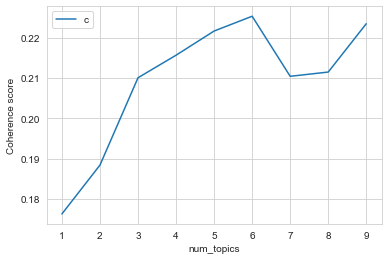

CPU times: user 23.2 s, sys: 8.37 s, total: 31.5 s
Wall time: 47.6 s


In [407]:
%%time
lmlist, c_v, numtopics = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=texts_clean, limit=10)

In [532]:
opt = pd.DataFrame(numtopics, c_v)
opt = opt.reset_index()
s = opt[opt['index'] == opt['index'].max()].iloc[0,1]

In [535]:
lmtopics = lmlist[s].show_topics(formatted=False)

In [534]:
lmtopics
# This is using all docs as training, but is not giving a topic modelig per document...

[(0,
  [('loan', 0.015804747),
   ('bank', 0.008366369),
   ('tax', 0.006252529),
   ('enterprise', 0.0058056996),
   ('software', 0.0038260485),
   ('client', 0.0037968578),
   ('forward_looking', 0.0032552427),
   ('separation', 0.0032400806),
   ('fair_value', 0.0029543287),
   ('fiscal', 0.0029414445)]),
 (1,
  [('tax', 0.0062325667),
   ('loan', 0.006126321),
   ('license', 0.0037291446),
   ('water', 0.0036818916),
   ('indebtedness', 0.003677287),
   ('affiliate', 0.0035056833),
   ('test', 0.003503142),
   ('bank', 0.0031002031),
   ('fiscal', 0.0028820708),
   ('separation', 0.0027618785)]),
 (2,
  [('loan', 0.013732899),
   ('tax', 0.007868865),
   ('bank', 0.005766971),
   ('fair_value', 0.0051717167),
   ('income', 0.004105689),
   ('test', 0.0037711302),
   ('deposit', 0.0034968767),
   ('portfolio', 0.0032791265),
   ('enterprise', 0.0032783067),
   ('water', 0.0027962103)]),
 (3,
  [('tax', 0.0061540822),
   ('loan', 0.005171495),
   ('fiscal', 0.004929189),
   ('water',

Rerun LDA with optimal number of topics from coherence graph (5)

In [334]:
ldamodel = LdaModel(corpus=corpus, num_topics=6, id2word=dictionary, per_word_topics = True, random_state=100) 
# Can use passes=2 or workers=2 to parallelize I believe too

View Topics

In [335]:
# Print the Keyword in the 10 topics
pprint(ldamodel.print_topics())
doc_lda = ldamodel[corpus]

[(0,
  '0.015*"loan" + 0.008*"bank" + 0.006*"tax" + 0.006*"enterprise" + '
  '0.004*"client" + 0.004*"software" + 0.004*"separation" + '
  '0.003*"forward_looking" + 0.003*"indebtedness" + 0.003*"fiscal"'),
 (1,
  '0.006*"tax" + 0.006*"loan" + 0.004*"license" + 0.004*"water" + 0.004*"test" '
  '+ 0.004*"indebtedness" + 0.003*"affiliate" + 0.003*"separation" + '
  '0.003*"fiscal" + 0.003*"client"'),
 (2,
  '0.012*"loan" + 0.008*"tax" + 0.006*"bank" + 0.004*"fair_value" + '
  '0.004*"income" + 0.004*"test" + 0.003*"enterprise" + 0.003*"deposit" + '
  '0.003*"portfolio" + 0.003*"separation"'),
 (3,
  '0.006*"tax" + 0.005*"loan" + 0.005*"fiscal" + 0.004*"client" + '
  '0.004*"enterprise" + 0.004*"water" + 0.004*"separation" + 0.003*"prospect" '
  '+ 0.003*"platform" + 0.003*"treatment"'),
 (4,
  '0.009*"store" + 0.007*"tax" + 0.004*"vice_president" + 0.004*"fiscal" + '
  '0.004*"part" + 0.004*"indebtedness" + 0.004*"loan" + 0.004*"client" + '
  '0.004*"vehicle" + 0.004*"license"'),
 (5,
  

Compute Model Perplexity and Coherence Score 

In [336]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Not the best coherence score but it will be better with all 10ks


Perplexity:  -7.6636069620998315

Coherence Score:  0.22531180818112165


Mallet’s version, however, often gives a better quality of topics.

In [337]:
data = comp10kbizdes.Text.values.tolist()

In [338]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.7284   
1            1             3.0              0.8089   
2            2             1.0              0.9971   
3            3             4.0              0.9993   
4            4             4.0              0.3165   
5            5             3.0              0.9390   
6            6             5.0              0.6223   
7            7             0.0              0.1667   
8            8             5.0              0.9474   
9            9             5.0              0.4801   

                                            Keywords  \
0  loan, bank, tax, enterprise, client, software,...   
1  tax, loan, fiscal, client, enterprise, water, ...   
2  tax, loan, license, water, test, indebtedness,...   
3  store, tax, vice_president, fiscal, part, inde...   
4  store, tax, vice_president, fiscal, part, inde...   
5  tax, loan, fiscal, client, enterprise, water, ...   
6  loan, tax, indebtedness, client, fiscal, incom...   
7  loan, bank, tax, enterprise, client, software,...   
8  loan, tax, indebtedness, client, fiscal, incom...   
9  loan, tax, indebtedness, client, fiscal, incom...   

                                                Text  
0  cik: 1681769company name: clancy corpform type...  
1  cik: 1584509company name: aramarkform type : 1...  
2  cik: 1603345company name: agentix corp form ty...  
3  cik: 866787company name: autozone incform type...  
4  cik: 1674862company name: ashland global holdi...  
5  cik: 1629205company name: my cloudz inc form t...  
6  cik: 1666138company name: atkore international...  
7  cik: 858655company name: haynes international ...  
8  cik: 1687926company name: kriptech internation...  
9  cik: 1589526company name: blue bird corpform t...

Merge dominant topics with originakl dataframe

In [341]:
Final_LDA = df_dominant_topic.merge(comp10kbizdes, left_on='Text', right_on='Text', how='outer')
Final_LDA.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.7284   
1            1             3.0              0.8089   
2            2             1.0              0.9971   
3            3             4.0              0.9993   
4            4             4.0              0.3165   
5            5             3.0              0.9390   
6            6             5.0              0.6223   
7            7             0.0              0.1667   
8            8             5.0              0.9474   
9            9             5.0              0.4801   

                                            Keywords  \
0  loan, bank, tax, enterprise, client, software,...   
1  tax, loan, fiscal, client, enterprise, water, ...   
2  tax, loan, license, water, test, indebtedness,...   
3  store, tax, vice_president, fiscal, part, inde...   
4  store, tax, vice_president, fiscal, part, inde...   
5  tax, loan, fiscal, client, enterprise, water, ...   
6  loan, tax, indebtedness, client, fiscal, incom...   
7  loan, bank, tax, enterprise, client, software,...   
8  loan, tax, indebtedness, client, fiscal, incom...   
9  loan, tax, indebtedness, client, fiscal, incom...   

                                                Text      CIK  Year  
0  cik: 1681769company name: clancy corpform type...  1681769  2018  
1  cik: 1584509company name: aramarkform type : 1...  1584509  2016  
2  cik: 1603345company name: agentix corp form ty...  1603345  2019  
3  cik: 866787company name: autozone incform type...   866787  2019  
4  cik: 1674862company name: ashland global holdi...  1674862  2018  
5  cik: 1629205company name: my cloudz inc form t...  1629205  2016  
6  cik: 1666138company name: atkore international...  1666138  2018  
7  cik: 858655company name: haynes international ...   858655  2016  
8  cik: 1687926company name: kriptech internation...  1687926  2019  
9  cik: 1589526company name: blue bird corpform t...  1589526  2018

Will need to manually create rule structure for topic names

Question: Would risk be better since industry can just come from NAICS? Or is this good since NAICS is outdated? 

## Use Case 4: Risk Topic Modeling

In [10]:
comp10ks_risk = comp10ks[['CIK', "Year", 'Text']]

In [41]:
comp10ks_risk_one['riskfac'] = comp10ks_risk_one.Text.apply(lambda x: re.findall('Item 1A.(.*?)Item 2.',x)[1])
comp10ks_risk_one['mandisc'] = comp10ks_risk_one.Text.apply(lambda x: re.findall('Item 7.(.*?)Item 8.',x)[1])
comp10ks_risk_one['fullrisktext'] = comp10ks_risk_one[['riskfac', 'mandisc']].apply(lambda x: ''.join(x), axis=1)

## Final: Bringing it All Together

In [373]:
Master_10K_Analysis = Final_LDA.merge(counts_summary, left_on=['CIK', 'Year'], right_on=['CIK', 'Year'], 
                                      how='right')
Master_10K_Analysis.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0          0.0             0.0              0.7284   
1          1.0             3.0              0.8089   
2          2.0             1.0              0.9971   
3          3.0             4.0              0.9993   
4          4.0             4.0              0.3165   
5          5.0             3.0              0.9390   
6          6.0             5.0              0.6223   
7          7.0             0.0              0.1667   
8          8.0             5.0              0.9474   
9          9.0             5.0              0.4801   

                                            Keywords  \
0  loan, bank, tax, enterprise, client, software,...   
1  tax, loan, fiscal, client, enterprise, water, ...   
2  tax, loan, license, water, test, indebtedness,...   
3  store, tax, vice_president, fiscal, part, inde...   
4  store, tax, vice_president, fiscal, part, inde...   
5  tax, loan, fiscal, client, enterprise, water, ...   
6  loan, tax, indebtedness, client, fiscal, incom...   
7  loan, bank, tax, enterprise, client, software,...   
8  loan, tax, indebtedness, client, fiscal, incom...   
9  loan, tax, indebtedness, client, fiscal, incom...   

                                                Text      CIK  Year   count  
0  cik: 1681769company name: clancy corpform type...  1681769  2018   62879  
1  cik: 1584509company name: aramarkform type : 1...  1584509  2016  572586  
2  cik: 1603345company name: agentix corp form ty...  1603345  2019   60697  
3  cik: 866787company name: autozone incform type...   866787  2019  260427  
4  cik: 1674862company name: ashland global holdi...  1674862  2018  981417  
5  cik: 1629205company name: my cloudz inc form t...  1629205  2016   26060  
6  cik: 1666138company name: atkore international...  1666138  2018  498524  
7  cik: 858655company name: haynes international ...   858655  2016  431856  
8  cik: 1687926company name: kriptech internation...  1687926  2019   49056  
9  cik: 1589526company name: blue bird corpform t...  1589526  2018  282883

In [374]:
Master_10K_Analysis = Master_10K_Analysis.merge(word_risk_wide, left_on=['CIK', 'Year'], right_on=['CIK', 'Year'], 
                                      how='right')
Master_10K_Analysis.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0          0.0             0.0              0.7284   
1          1.0             3.0              0.8089   
2          2.0             1.0              0.9971   
3          3.0             4.0              0.9993   
4          4.0             4.0              0.3165   
5          5.0             3.0              0.9390   
6          6.0             5.0              0.6223   
7          7.0             0.0              0.1667   
8          8.0             5.0              0.9474   
9          9.0             5.0              0.4801   

                                            Keywords  \
0  loan, bank, tax, enterprise, client, software,...   
1  tax, loan, fiscal, client, enterprise, water, ...   
2  tax, loan, license, water, test, indebtedness,...   
3  store, tax, vice_president, fiscal, part, inde...   
4  store, tax, vice_president, fiscal, part, inde...   
5  tax, loan, fiscal, client, enterprise, water, ...   
6  loan, tax, indebtedness, client, fiscal, incom...   
7  loan, bank, tax, enterprise, client, software,...   
8  loan, tax, indebtedness, client, fiscal, incom...   
9  loan, tax, indebtedness, client, fiscal, incom...   

                                                Text      CIK  Year   count  \
0  cik: 1681769company name: clancy corpform type...  1681769  2018   62879   
1  cik: 1584509company name: aramarkform type : 1...  1584509  2016  572586   
2  cik: 1603345company name: agentix corp form ty...  1603345  2019   60697   
3  cik: 866787company name: autozone incform type...   866787  2019  260427   
4  cik: 1674862company name: ashland global holdi...  1674862  2018  981417   
5  cik: 1629205company name: my cloudz inc form t...  1629205  2016   26060   
6  cik: 1666138company name: atkore international...  1666138  2018  498524   
7  cik: 858655company name: haynes international ...   858655  2016  431856   
8  cik: 1687926company name: kriptech internation...  1687926  2019   49056   
9  cik: 1589526company name: blue bird corpform t...  1589526  2018  282883   

   anticipate  believe  depend  fluctuate  likelihood  possible  predict  \
0         2.0     12.0     0.0        0.0         0.0       1.0      0.0   
1         9.0     25.0     1.0        4.0         3.0       6.0      4.0   
2         0.0     13.0     0.0        0.0         5.0      14.0      0.0   
3         5.0     39.0     2.0        4.0         0.0      11.0      4.0   
4         4.0      3.0     1.0       14.0         3.0      47.0     24.0   
5         4.0      9.0     0.0        0.0         1.0       1.0      2.0   
6        11.0     37.0     7.0        7.0        15.0      13.0      5.0   
7         2.0     21.0     9.0        3.0         3.0      14.0      4.0   
8         2.0      8.0     0.0        0.0         0.0       0.0      0.0   
9        14.0     20.0     7.0        1.0         0.0       9.0      5.0   

    risk  uncertain  
0    8.0        3.0  
1   71.0       19.0  
2   25.0       13.0  
3  109.0       22.0  
4   87.0       61.0  
5   14.0        3.0  
6  120.0       81.0  
7   82.0        7.0  
8   10.0        7.0  
9   65.0       48.0

In [375]:
cols = Master_10K_Analysis.columns.tolist()
cols.insert(0, cols.pop(cols.index('Year')))
Master_10K_Analysis = Master_10K_Analysis.reindex(columns=cols)
cols = Master_10K_Analysis.columns.tolist()
cols.insert(0, cols.pop(cols.index('CIK')))
Master_10K_Analysis = Master_10K_Analysis.reindex(columns=cols)
Master_10K_Analysis.head(10)

CIK  Year  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0  1681769  2018          0.0             0.0              0.7284   
1  1584509  2016          1.0             3.0              0.8089   
2  1603345  2019          2.0             1.0              0.9971   
3   866787  2019          3.0             4.0              0.9993   
4  1674862  2018          4.0             4.0              0.3165   
5  1629205  2016          5.0             3.0              0.9390   
6  1666138  2018          6.0             5.0              0.6223   
7   858655  2016          7.0             0.0              0.1667   
8  1687926  2019          8.0             5.0              0.9474   
9  1589526  2018          9.0             5.0              0.4801   

                                            Keywords  \
0  loan, bank, tax, enterprise, client, software,...   
1  tax, loan, fiscal, client, enterprise, water, ...   
2  tax, loan, license, water, test, indebtedness,...   
3  store, tax, vice_president, fiscal, part, inde...   
4  store, tax, vice_president, fiscal, part, inde...   
5  tax, loan, fiscal, client, enterprise, water, ...   
6  loan, tax, indebtedness, client, fiscal, incom...   
7  loan, bank, tax, enterprise, client, software,...   
8  loan, tax, indebtedness, client, fiscal, incom...   
9  loan, tax, indebtedness, client, fiscal, incom...   

                                                Text   count  anticipate  \
0  cik: 1681769company name: clancy corpform type...   62879         2.0   
1  cik: 1584509company name: aramarkform type : 1...  572586         9.0   
2  cik: 1603345company name: agentix corp form ty...   60697         0.0   
3  cik: 866787company name: autozone incform type...  260427         5.0   
4  cik: 1674862company name: ashland global holdi...  981417         4.0   
5  cik: 1629205company name: my cloudz inc form t...   26060         4.0   
6  cik: 1666138company name: atkore international...  498524        11.0   
7  cik: 858655company name: haynes international ...  431856         2.0   
8  cik: 1687926company name: kriptech internation...   49056         2.0   
9  cik: 1589526company name: blue bird corpform t...  282883        14.0   

   believe  depend  fluctuate  likelihood  possible  predict   risk  uncertain  
0     12.0     0.0        0.0         0.0       1.0      0.0    8.0        3.0  
1     25.0     1.0        4.0         3.0       6.0      4.0   71.0       19.0  
2     13.0     0.0        0.0         5.0      14.0      0.0   25.0       13.0  
3     39.0     2.0        4.0         0.0      11.0      4.0  109.0       22.0  
4      3.0     1.0       14.0         3.0      47.0     24.0   87.0       61.0  
5      9.0     0.0        0.0         1.0       1.0      2.0   14.0        3.0  
6     37.0     7.0        7.0        15.0      13.0      5.0  120.0       81.0  
7     21.0     9.0        3.0         3.0      14.0      4.0   82.0        7.0  
8      8.0     0.0        0.0         0.0       0.0      0.0   10.0        7.0  
9     20.0     7.0        1.0         0.0       9.0      5.0   65.0       48.0

In [ ]:
#Master_10K_Analysis = Master_10K_Analysis.merge(word_risk_wide, left_on=['Company', 'Year'], right_on=['Company', 'Year'], 
                                      #how='right')
#Master_10K_Analysis.head(10)

In [376]:
Master_10K_Analysis = Master_10K_Analysis.drop("Text", axis=1)

In [377]:
Master_10K_Analysis.head(10)

CIK  Year  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0  1681769  2018          0.0             0.0              0.7284   
1  1584509  2016          1.0             3.0              0.8089   
2  1603345  2019          2.0             1.0              0.9971   
3   866787  2019          3.0             4.0              0.9993   
4  1674862  2018          4.0             4.0              0.3165   
5  1629205  2016          5.0             3.0              0.9390   
6  1666138  2018          6.0             5.0              0.6223   
7   858655  2016          7.0             0.0              0.1667   
8  1687926  2019          8.0             5.0              0.9474   
9  1589526  2018          9.0             5.0              0.4801   

                                            Keywords   count  anticipate  \
0  loan, bank, tax, enterprise, client, software,...   62879         2.0   
1  tax, loan, fiscal, client, enterprise, water, ...  572586         9.0   
2  tax, loan, license, water, test, indebtedness,...   60697         0.0   
3  store, tax, vice_president, fiscal, part, inde...  260427         5.0   
4  store, tax, vice_president, fiscal, part, inde...  981417         4.0   
5  tax, loan, fiscal, client, enterprise, water, ...   26060         4.0   
6  loan, tax, indebtedness, client, fiscal, incom...  498524        11.0   
7  loan, bank, tax, enterprise, client, software,...  431856         2.0   
8  loan, tax, indebtedness, client, fiscal, incom...   49056         2.0   
9  loan, tax, indebtedness, client, fiscal, incom...  282883        14.0   

   believe  depend  fluctuate  likelihood  possible  predict   risk  uncertain  
0     12.0     0.0        0.0         0.0       1.0      0.0    8.0        3.0  
1     25.0     1.0        4.0         3.0       6.0      4.0   71.0       19.0  
2     13.0     0.0        0.0         5.0      14.0      0.0   25.0       13.0  
3     39.0     2.0        4.0         0.0      11.0      4.0  109.0       22.0  
4      3.0     1.0       14.0         3.0      47.0     24.0   87.0       61.0  
5      9.0     0.0        0.0         1.0       1.0      2.0   14.0        3.0  
6     37.0     7.0        7.0        15.0      13.0      5.0  120.0       81.0  
7     21.0     9.0        3.0         3.0      14.0      4.0   82.0        7.0  
8      8.0     0.0        0.0         0.0       0.0      0.0   10.0        7.0  
9     20.0     7.0        1.0         0.0       9.0      5.0   65.0       48.0

In [378]:
comp10ks_sub = comp10ks[['CIK', 'Year', 'CompName', 'Address', 'City', 'State']]

In [379]:
Master_10K_Analysis = Master_10K_Analysis.merge(comp10ks_sub, left_on=['CIK', 'Year'], right_on=['CIK', 'Year'], 
                                      how='right')
Master_10K_Analysis.head(10)

CIK  Year  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0  1681769  2018          0.0             0.0              0.7284   
1  1584509  2016          1.0             3.0              0.8089   
2  1603345  2019          2.0             1.0              0.9971   
3   866787  2019          3.0             4.0              0.9993   
4  1674862  2018          4.0             4.0              0.3165   
5  1629205  2016          5.0             3.0              0.9390   
6  1666138  2018          6.0             5.0              0.6223   
7   858655  2016          7.0             0.0              0.1667   
8  1687926  2019          8.0             5.0              0.9474   
9  1589526  2018          9.0             5.0              0.4801   

                                            Keywords   count  anticipate  \
0  loan, bank, tax, enterprise, client, software,...   62879         2.0   
1  tax, loan, fiscal, client, enterprise, water, ...  572586         9.0   
2  tax, loan, license, water, test, indebtedness,...   60697         0.0   
3  store, tax, vice_president, fiscal, part, inde...  260427         5.0   
4  store, tax, vice_president, fiscal, part, inde...  981417         4.0   
5  tax, loan, fiscal, client, enterprise, water, ...   26060         4.0   
6  loan, tax, indebtedness, client, fiscal, incom...  498524        11.0   
7  loan, bank, tax, enterprise, client, software,...  431856         2.0   
8  loan, tax, indebtedness, client, fiscal, incom...   49056         2.0   
9  loan, tax, indebtedness, client, fiscal, incom...  282883        14.0   

   believe  depend  fluctuate  likelihood  possible  predict   risk  \
0     12.0     0.0        0.0         0.0       1.0      0.0    8.0   
1     25.0     1.0        4.0         3.0       6.0      4.0   71.0   
2     13.0     0.0        0.0         5.0      14.0      0.0   25.0   
3     39.0     2.0        4.0         0.0      11.0      4.0  109.0   
4      3.0     1.0       14.0         3.0      47.0     24.0   87.0   
5      9.0     0.0        0.0         1.0       1.0      2.0   14.0   
6     37.0     7.0        7.0        15.0      13.0      5.0  120.0   
7     21.0     9.0        3.0         3.0      14.0      4.0   82.0   
8      8.0     0.0        0.0         0.0       0.0      0.0   10.0   
9     20.0     7.0        1.0         0.0       9.0      5.0   65.0   

   uncertain                         CompName  \
0        3.0                      Clancy Corp   
1       19.0                          Aramark   
2       13.0                    Agentix Corp.   
3       22.0                     AUTOZONE INC   
4       61.0      ASHLAND GLOBAL HOLDINGS INC   
5        3.0                  My Cloudz, Inc.   
6       81.0  Atkore International Group Inc.   
7        7.0         HAYNES INTERNATIONAL INC   
8        7.0     Kriptech International Corp.   
9       48.0                   Blue Bird Corp   

                                             Address                  City  \
0                                   5348 VEGAS DRIVE             LAS VEGAS   
1                                 1101 MARKET STREET          PHILADELPHIA   
2      32932 PACIFIC COAST HIGHWAY STREET 2: #14-254            DANA POINT   
3                                 123 SOUTH FRONT ST               MEMPHIS   
4                              50 E RIVERCENTER BLVD             COVINGTON   
5                             112 NORTH CURRY STREET           CARSON CITY   
6                         16100 SOUTH LATHROP AVENUE                HARVEY   
7           1020 WEST PARK AVE STREET 2: PO BOX 9013                KOKOMO   
8  21/37 MOO 4, BANGRAK STREET 2: BOPHUT, KOH SAMUI,  SURAT THANI PROVINCE   
9            3920 ARKWRIGHT ROAD STREET 2: SUITE 200                 MACON   

  State  
0    NV  
1    PA  
2    CA  
3    TN  
4    KY  
5    NV  
6    IL  
7    IN  
8    W1  
9    GA

In [380]:
Master_10K_Analysis = Master_10K_Analysis.dropna(subset=['Dominant_Topic'])

### Add Coordinates

In [382]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
Master_10K_Analysis['Coordinates'] = Master_10K_Analysis['Address'].apply(geolocator.geocode)

In [383]:
Master_10K_Analysis

CIK  Year  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0    1681769  2018          0.0             0.0              0.7284   
1    1584509  2016          1.0             3.0              0.8089   
2    1603345  2019          2.0             1.0              0.9971   
3     866787  2019          3.0             4.0              0.9993   
4    1674862  2018          4.0             4.0              0.3165   
..       ...   ...          ...             ...                 ...   
118  1680132  2017        111.0             0.0              0.9962   
119  1603345  2016        112.0             1.0              0.9972   
120  1685570  2017        113.0             0.0              0.9419   
121  1621221  2018        114.0             1.0              0.5776   
122  1631282  2018        115.0             3.0              0.5309   

                                              Keywords   count  anticipate  \
0    loan, bank, tax, enterprise, client, software,...   62879         2.0   
1    tax, loan, fiscal, client, enterprise, water, ...  572586         9.0   
2    tax, loan, license, water, test, indebtedness,...   60697         0.0   
3    store, tax, vice_president, fiscal, part, inde...  260427         5.0   
4    store, tax, vice_president, fiscal, part, inde...  981417         4.0   
..                                                 ...     ...         ...   
118  loan, bank, tax, enterprise, client, software,...   60630         1.0   
119  tax, loan, license, water, test, indebtedness,...   63233         0.0   
120  loan, bank, tax, enterprise, client, software,...   68546         1.0   
121  tax, loan, license, water, test, indebtedness,...   66978         0.0   
122  tax, loan, fiscal, client, enterprise, water, ...   77018         5.0   

     believe  depend  ...  likelihood  possible  predict   risk  uncertain  \
0       12.0     0.0  ...         0.0       1.0      0.0    8.0        3.0   
1       25.0     1.0  ...         3.0       6.0      4.0   71.0       19.0   
2       13.0     0.0  ...         5.0      14.0      0.0   25.0       13.0   
3       39.0     2.0  ...         0.0      11.0      4.0  109.0       22.0   
4        3.0     1.0  ...         3.0      47.0     24.0   87.0       61.0   
..       ...     ...  ...         ...       ...      ...    ...        ...   
118      7.0     0.0  ...         0.0       1.0      0.0    8.0        3.0   
119     17.0     0.0  ...         5.0      17.0      0.0   36.0       12.0   
120     11.0     0.0  ...         0.0       2.0      0.0   14.0        0.0   
121     10.0     3.0  ...         0.0       3.0      0.0   49.0        0.0   
122     21.0     7.0  ...         1.0      17.0      4.0   46.0       10.0   

                        CompName  \
0                    Clancy Corp   
1                        Aramark   
2                  Agentix Corp.   
3                   AUTOZONE INC   
4    ASHLAND GLOBAL HOLDINGS INC   
..                           ...   
118                  Geant Corp.   
119         FairWind Energy Inc.   
120                 KALMIN CORP.   
121     ARTELO BIOSCIENCES, INC.   
122                 DATASEA INC.   

                                               Address          City State  \
0                                     5348 VEGAS DRIVE     LAS VEGAS    NV   
1                                   1101 MARKET STREET  PHILADELPHIA    PA   
2        32932 PACIFIC COAST HIGHWAY STREET 2: #14-254    DANA POINT    CA   
3                                   123 SOUTH FRONT ST       MEMPHIS    TN   
4                                50 E RIVERCENTER BLVD     COVINGTON    KY   
..                                                 ...           ...   ...   
118                                    IRUKUPALEM 2/56        GUNTUR    K7   
119      32932 PACIFIC COAST HIGHWAY STREET 2: #14-254    DANA POINT    CA   
120                                       ALBERDI 1045       CAACUPE    R4   
121                     888 PROSPECT STREET, SUITE 210      LA JOLLA 

In [384]:
Master_10K_Analysis['Latitude'] = Master_10K_Analysis.Coordinates.apply(lambda x: (x.latitude) if x is not None else x)
Master_10K_Analysis['Longitude'] = Master_10K_Analysis.Coordinates.apply(lambda x: (x.longitude) if x is not None else x)

In [385]:
Master_10K_Analysis

CIK  Year  Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0    1681769  2018          0.0             0.0              0.7284   
1    1584509  2016          1.0             3.0              0.8089   
2    1603345  2019          2.0             1.0              0.9971   
3     866787  2019          3.0             4.0              0.9993   
4    1674862  2018          4.0             4.0              0.3165   
..       ...   ...          ...             ...                 ...   
118  1680132  2017        111.0             0.0              0.9962   
119  1603345  2016        112.0             1.0              0.9972   
120  1685570  2017        113.0             0.0              0.9419   
121  1621221  2018        114.0             1.0              0.5776   
122  1631282  2018        115.0             3.0              0.5309   

                                              Keywords   count  anticipate  \
0    loan, bank, tax, enterprise, client, software,...   62879         2.0   
1    tax, loan, fiscal, client, enterprise, water, ...  572586         9.0   
2    tax, loan, license, water, test, indebtedness,...   60697         0.0   
3    store, tax, vice_president, fiscal, part, inde...  260427         5.0   
4    store, tax, vice_president, fiscal, part, inde...  981417         4.0   
..                                                 ...     ...         ...   
118  loan, bank, tax, enterprise, client, software,...   60630         1.0   
119  tax, loan, license, water, test, indebtedness,...   63233         0.0   
120  loan, bank, tax, enterprise, client, software,...   68546         1.0   
121  tax, loan, license, water, test, indebtedness,...   66978         0.0   
122  tax, loan, fiscal, client, enterprise, water, ...   77018         5.0   

     believe  depend  ...  predict   risk  uncertain  \
0       12.0     0.0  ...      0.0    8.0        3.0   
1       25.0     1.0  ...      4.0   71.0       19.0   
2       13.0     0.0  ...      0.0   25.0       13.0   
3       39.0     2.0  ...      4.0  109.0       22.0   
4        3.0     1.0  ...     24.0   87.0       61.0   
..       ...     ...  ...      ...    ...        ...   
118      7.0     0.0  ...      0.0    8.0        3.0   
119     17.0     0.0  ...      0.0   36.0       12.0   
120     11.0     0.0  ...      0.0   14.0        0.0   
121     10.0     3.0  ...      0.0   49.0        0.0   
122     21.0     7.0  ...      4.0   46.0       10.0   

                        CompName  \
0                    Clancy Corp   
1                        Aramark   
2                  Agentix Corp.   
3                   AUTOZONE INC   
4    ASHLAND GLOBAL HOLDINGS INC   
..                           ...   
118                  Geant Corp.   
119         FairWind Energy Inc.   
120                 KALMIN CORP.   
121     ARTELO BIOSCIENCES, INC.   
122                 DATASEA INC.   

                                               Address          City State  \
0                                     5348 VEGAS DRIVE     LAS VEGAS    NV   
1                                   1101 MARKET STREET  PHILADELPHIA    PA   
2        32932 PACIFIC COAST HIGHWAY STREET 2: #14-254    DANA POINT    CA   
3                                   123 SOUTH FRONT ST       MEMPHIS    TN   
4                                50 E RIVERCENTER BLVD     COVINGTON    KY   
..                                                 ...           ...   ...   
118                                    IRUKUPALEM 2/56        GUNTUR    K7   
119      32932 PACIFIC COAST HIGHWAY STREET 2: #14-254    DANA POINT    CA   
120                                       ALBERDI 1045       CAACUPE    R4   
121                     888 PROSPECT STREET, SUITE 210      LA JOLLA    CA   
122  1 XINGHUO RD, CHANGNING BLDG, STE.11D2E STREET...       BEIJING    F4   

                                           Coordinates   Latitude   Longitude  
0    (5348, Vegas Drive, Eastland Heights, Las Vega...  36.188306 -115.214188  
1    (Tennessee 

In [386]:
Master_10K_Analysis.to_csv(r'10kTextAnalytics_Sample_Master_020420_withcoords.csv')